<a href="https://colab.research.google.com/github/agranan/SOC2024/blob/main/SOCAssignment2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [19]:
data_dir = '/content/drive/MyDrive/PracticeColab/ImageClassification'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}


In [22]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = True, num_workers = 2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

class_names = image_datasets['train'].classes
class_names

{'train': 104, 'val': 20}


['glasses', 'noglasses']

In [25]:
model = models.resnet18(pretrained = True)

for name, param in model.named_parameters():
  if "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
num_epochs = 10
for epoch in range(num_epochs):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        if phase == 'train':
          loss.backward()
          optimizer.step()

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

print("Training complete")

train Loss: 2.8284 Acc: 0.4327
val Loss: 0.6031 Acc: 0.6500
train Loss: 0.6454 Acc: 0.6635
val Loss: 0.6268 Acc: 0.6500
train Loss: 0.6271 Acc: 0.6442
val Loss: 0.4750 Acc: 0.7500
train Loss: 0.8608 Acc: 0.6731
val Loss: 0.4073 Acc: 0.8000
train Loss: 0.4045 Acc: 0.7788
val Loss: 0.5460 Acc: 0.6000
train Loss: 0.5288 Acc: 0.7404
val Loss: 0.6138 Acc: 0.7500
train Loss: 0.5022 Acc: 0.7692
val Loss: 0.4180 Acc: 0.8000
train Loss: 0.5347 Acc: 0.8077
val Loss: 0.4464 Acc: 0.8000
train Loss: 0.2486 Acc: 0.8846
val Loss: 0.3030 Acc: 0.9000
train Loss: 0.2747 Acc: 0.8846
val Loss: 0.4037 Acc: 0.8500
Training complete


In [28]:
torch.save(model.state_dict(), '/content/drive/MyDrive/PracticeColab/ImageClassification/model_save.pth')

Testing

In [29]:
import torch
from torchvision import models, transforms
from PIL import Image


In [31]:
model = models.resnet18(pretrained = True)
model.fc = nn.Linear(model.fc.in_features, 1000)
model.load_state_dict(torch.load('/content/drive/MyDrive/PracticeColab/ImageClassification/model_save.pth'))
model.eval()

new_model = models.resnet18(pretrained = True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)

new_model.fc.weight.data = model.fc.weight.data[0:2]
new_model.fc.bias.data = model.fc.bias.data[0:2]


In [43]:
image_path = '/content/drive/MyDrive/PracticeColab/ImageClassification/test/row-12-column-2.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

In [44]:
with torch.no_grad():
  output = model(input_batch)

_, predicted_class = output.max(1)

class_names = ['glasses', 'noglasses']
predicted_class_name = class_names[predicted_class.item()]

print(f'The predicted class is: {predicted_class_name}')

The predicted class is: noglasses


Text(10, 10, 'Predicted: noglasses')

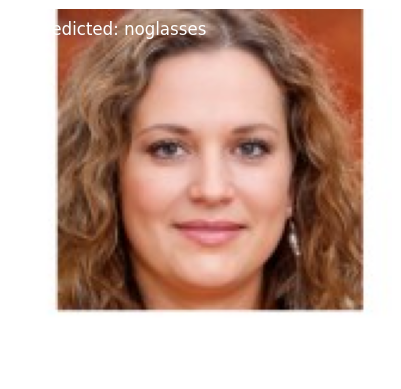

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize = 12, color = 'white')